# **Importing the required libraries**

In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

<ipython-input-1-2b97d8eaa681>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# **Extracting Frames**

In [2]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16
 

# DATASET_DIR = "/kaggle/input/rwf2000/RWF-2000/train"
DATASET_DIRS = [
    "/kaggle/input/rwf2000/RWF-2000/train",
    "/kaggle/input/rwf2000/RWF-2000/val",
    "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset",
    
]
 
CLASSES_LIST = ["Violence","NonViolence"]
CLASS_MAPPING = {
    "Violence": "Violence",
    "Fight": "Violence",
    "NonViolence": "NonViolence",
    "NonFight": "NonViolence"
}


In [3]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

# **Creating the Data**

In [4]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for dataset_dir in DATASET_DIRS:
        for original_class, merged_class in CLASS_MAPPING.items():
            class_index = CLASSES_LIST.index(merged_class)
            class_path = os.path.join(dataset_dir, original_class)

            if not os.path.exists(class_path):
                continue  # Skip if the folder doesn't exist

            print(f'Extracting Data from: {class_path}')
            files_list = os.listdir(class_path)

            for file_name in files_list:
                video_file_path = os.path.join(class_path, file_name)
                frames = frames_extraction(video_file_path)

                if len(frames) == SEQUENCE_LENGTH:
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

    return np.asarray(features), np.array(labels), video_files_paths


In [5]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data from: /kaggle/input/rwf2000/RWF-2000/train/Fight
Extracting Data from: /kaggle/input/rwf2000/RWF-2000/train/NonFight
Extracting Data from: /kaggle/input/rwf2000/RWF-2000/val/Fight
Extracting Data from: /kaggle/input/rwf2000/RWF-2000/val/NonFight
Extracting Data from: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence
Extracting Data from: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence


In [9]:
# Saving the extracted data
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [10]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

# **Encoding and Splitting Training-Testing Sets**

In [18]:
# convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [19]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [20]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(3600, 16, 64, 64, 3) (3600, 2)
(400, 16, 64, 64, 3) (400, 2)


# **Importing MobileNet and Fine-Tuning it.**

In [21]:
from keras.applications.mobilenet_v2 import MobileNetV2

weight_path = "/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

mobilenet = MobileNetV2( include_top=False , weights=weight_path)

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

#mobilenet.summary()

In [22]:
# mobilenet.summary()

# **Building The Model**

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_model():
    model = Sequential()
    
    # Specifying Input to match features shape
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    model.add(TimeDistributed(mobilenet))
    
    # Batch normalization to stabilize training
    model.add(TimeDistributed(BatchNormalization()))
    
    model.add(Dropout(0.4)) 
    
    model.add(TimeDistributed(Flatten()))
    
    # Use an LSTM that only returns the final output (not the whole sequence)
    lstm_fw = LSTM(units=64, return_sequences=False, kernel_regularizer=l2(0.01))
    lstm_bw = LSTM(units=64, go_backwards=True, return_sequences=False, kernel_regularizer=l2(0.01))
    
    # When using Bidirectional with non-sequence output, you don't need to set backward_layer explicitly
    model.add(Bidirectional(lstm_fw))  # Automatically handles both directions
    
    model.add(Dropout(0.4))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    model.summary()
    
    return model


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 16, 2, 2, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 16, 2, 2, 1280)      │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 2, 2, 1280)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 16, 5120)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │       2,654,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 4,996,066 (19.06 MB)

 Trainable params: 4,416,098 (16.85 MB)

 Non-trainable params: 579,968 (2.21 MB)

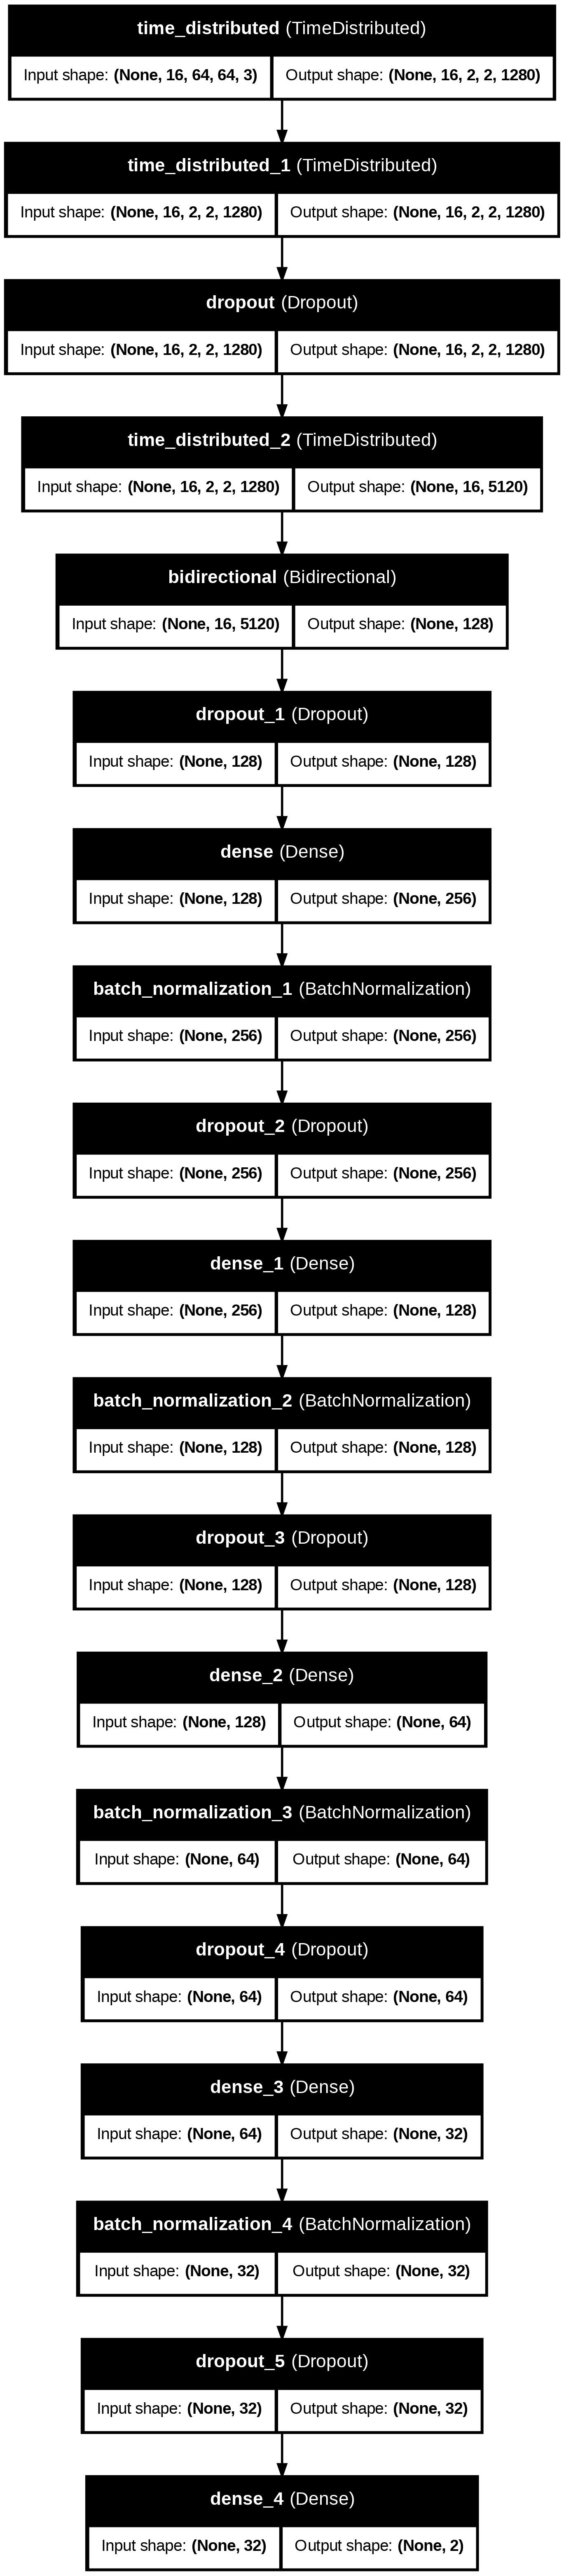

In [25]:
# Constructing the Model
MoBiLSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# **Specifying Callbacks and Fitting**

In [27]:
import tensorflow as tf
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)
 
# Compiling the model 
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
 
# Fitting the model 
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 318s 605ms/step - accuracy: 0.5003 - loss: 15.2649 - val_accuracy: 0.5056 - val_loss: 13.7152 - learning_rate: 0.0100
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 195s 542ms/step - accuracy: 0.5016 - loss: 13.2766 - val_accuracy: 0.5472 - val_loss: 11.9746 - learning_rate: 0.0100
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 190s 528ms/step - accuracy: 0.4916 - loss: 11.5959 - val_accuracy: 0.5167 - val_loss: 10.4701 - learning_rate: 0.0100
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 203s 532ms/step - accuracy: 0.4973 - loss: 10.1408 - val_accuracy: 0.4750 - val_loss: 9.1765 - learning_rate: 0.0100
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 202s 532ms/step - accuracy: 0.5137 - loss: 8.8888 - val_accuracy: 0.5389 - val_loss: 8.0462 - learning_rate: 0.0100
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 191s 530ms/step - accuracy: 0.5059 - loss: 7.8016 - val_accuracy: 0.5500 - val_loss: 7.0727 - learning_rate: 0.0100
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 191s 529ms/step -

In [28]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 653ms/step - accuracy: 0.8220 - loss: 0.4573


In [51]:
# Save the model in the current working directory
MoBiLSTM_model.save('/kaggle/working/MoBiLSTM_model.h5')

# **Model Evaluation**

In [30]:
import matplotlib.pyplot as plt

def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # Extract metric values from training history
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Get the number of epochs
    epochs = range(len(metric_value_1))
    
    # Create the plot
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    
    # Add title and labels
    plt.title(str(plot_name))
    plt.xlabel('Epochs')  # Adding x-axis label
    plt.ylabel('Value')   # Adding y-axis label
    
    # Add a legend to the plot
    plt.legend()
    
    plt.grid(True)
    
    # Show the plot
    plt.show()


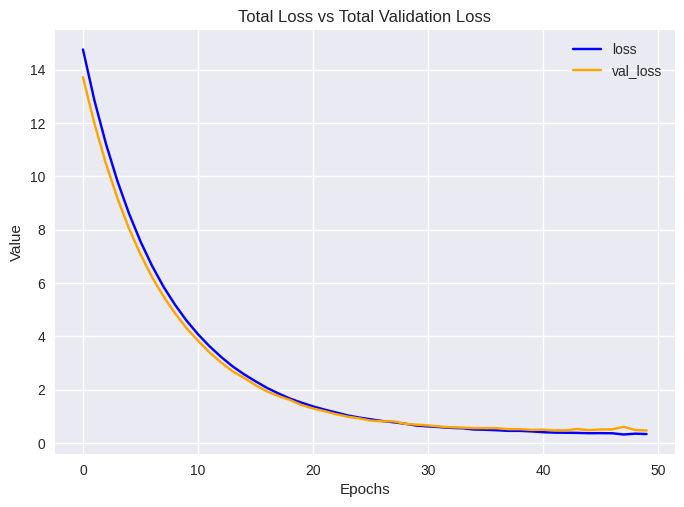

In [31]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

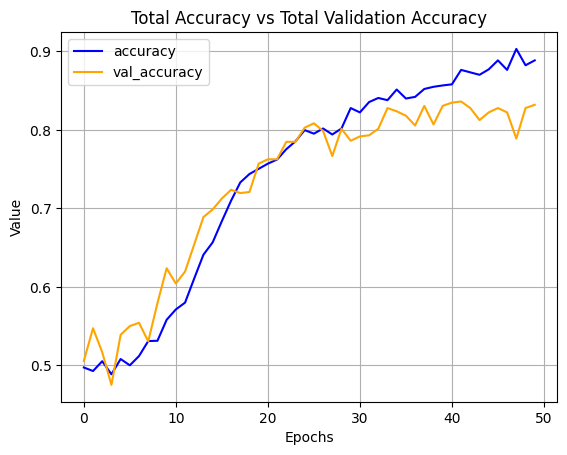

In [50]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Predicting the Test Set**

In [33]:
labels_predict = MoBiLSTM_model.predict(features_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step 


In [34]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [35]:
labels_test_normal.shape , labels_predict.shape

((400,), (400,))

Accuracy Score

In [36]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8275


Confusion Matrix

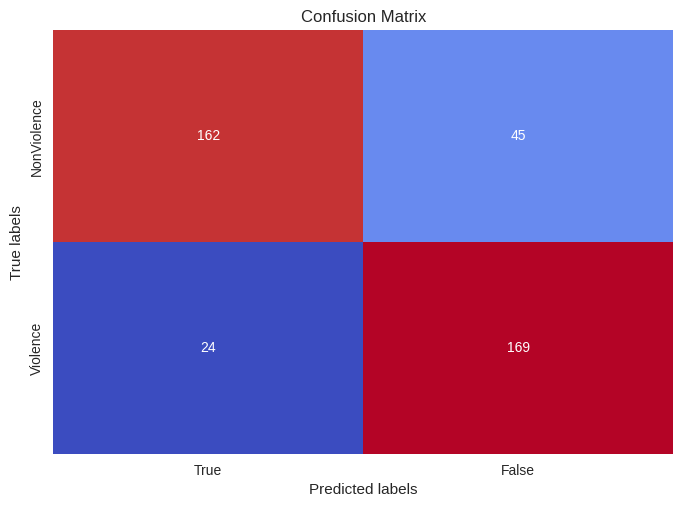

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(labels_test_normal, labels_predict)

# Create the plot
ax = plt.subplot()

# Plot heatmap with custom colormap
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='coolwarm', cbar=False)

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set custom tick labels
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

# Show the plot
plt.show()


In [38]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.87      0.78      0.82       207
           1       0.79      0.88      0.83       193

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

